###### <p style="text-align: center; font-size: 24px;"><strong>Projet 8: Réalisez un dashboard et assurez une veille technique</strong></p>

**Veille technique : Test d’un modèle NLP récent sur la classification automatique de produits**

**Objectif de la mission** <br>
Dans le cadre d’une veille technique demandée par l’équipe Data Science, ce notebook a pour objectif d’étudier une technique de modélisation de données textuelles récente (moins de 5 ans), d’en expliquer les principes, et d’en tester les performances sur un jeu de données e-commerce déjà exploré dans un précédent projet (Place de marché).

Nous nous appuierons sur un jeu de données contenant des descriptions textuelles de produits, dans un objectif de classification automatique.

**Contexte du cas d’usage : Place de marché**<br>
Dans un contexte où les vendeurs renseignent manuellement les catégories produits, ce processus est peu fiable et difficilement scalable. Une automatisation de la classification à partir des descriptions textuelles est donc souhaitée.

**Veille technique : approche récente à tester**<br>
Dans ce notebook, nous allons :
- Mettre en œuvre et évaluer DistilBERT, issu de BERT, modèle de référence en NLP depuis 2018, pour encoder les descriptions produits et réaliser la classification.

- Mettre en œuvre et évaluer DeBERTa, modèle plus récent et innovant (Microsoft, 2020), pour la même tâche.

- Comparer quantitativement et qualitativement les performances des deux modèles sur le même jeu de données.

L’objectif est de produire une preuve de concept (POC) et une note méthodologique qui expliquent :

- Les fondements théoriques des modèles explorés,

- Leur mise en œuvre concrète,

- Leur valeur ajoutée (ou non) dans le contexte métier.

**Structure du notebook**
- Présentation du jeu de données et du cas d’usage

- Implémentation et évaluation de DistilBERT

- Implémentation et évaluation de DeBERTa

- Comparaison des performances (quantitative + qualitative)

**À noter**<br>
Ce notebook se concentre sur la partie technique de la veille. La note méthodologique associée approfondira les aspects bibliographiques, les fondements mathématiques et les impacts métiers.

# Importation des librairies

In [1]:
# LIBRAIRIES DE BASE
import re                             # Expressions régulières pour le nettoyage de texte
import numpy as np                    # Calcul numérique
import pandas as pd                   # Manipulation de données tabulaires

# AFFICHAGE & VISUALISATION
import matplotlib.pyplot as plt       # Visualisation de base
import seaborn as sns                 # Visualisation statistique
import missingno as msno              # Visualisation des valeurs manquantes

# TRANSFORMERS & EMBEDDINGS
from transformers import AutoTokenizer, AutoModel  # Modèles préentraînés de Hugging Face
import torch                                       # Backend pour les tensors et calculs GPU
from tqdm.notebook import tqdm                     # Progress bar (mode notebook)

# RÉDUCTION DE DIMENSION
from sklearn.decomposition import PCA              # Analyse en composantes principales
from sklearn.manifold import TSNE                  # T-SNE pour visualisation 2D/3D

# CLUSTERING & ÉVALUATION
from sklearn.cluster import KMeans                 # Clustering non supervisé
from sklearn import metrics                        # Évaluation clustering
from sklearn.metrics import (                      # Métriques pour cluster et classification
    silhouette_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    adjusted_rand_score,
    classification_report,
    confusion_matrix,
    accuracy_score
)

# APPRENTISSAGE SUPERVISÉ
from sklearn.model_selection import train_test_split         # Séparation train/test
from sklearn.linear_model import LogisticRegression          # Classifieur linéaire
from sklearn.inspection import permutation_importance        # Importance des features

# EXPLICABILITÉ
import shap                                        # SHAP pour l’interprétabilité des modèles

# Importation des données

In [2]:
# Chargement du fichier
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

# Afficher les premières lignes
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [3]:
print('Structure du fichier:')
print(df.shape)

print('-' * 70)

print('Informations sur les colonnes:')
df.info()

Structure du fichier:
(1050, 15)
----------------------------------------------------------------------
Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 1

Ce fichier contient 1 050 produits issus du site e-commerce Flipkart, chacun avec 15 colonnes décrivant différentes caractéristiques du produit. Voici une description des colonnes :

| Colonne                   | Description                                                                 |
|:--------------------------|:----------------------------------------------------------------------------|
| `uniq_id`                 | Identifiant unique du produit                                               |
| `crawl_timestamp`         | Date et heure de récupération des données (scraping)                        |
| `product_url`             | Lien vers la page du produit sur Flipkart                                  |
| `product_name`            | Nom du produit                                                              |
| `product_category_tree`   | Catégorie hiérarchique du produit (ex. : Home >> Linge >> Draps...)         |
| `pid`                     | Identifiant produit interne (product ID)                                   |
| `retail_price`            | Prix de vente initial (avant réduction)                                    |
| `discounted_price`        | Prix après réduction                                                        |
| `image`                   | Nom du fichier image du produit                                             |
| `is_FK_Advantage_product` | Produit éligible au service "Flipkart Advantage" (similaire à Amazon Prime)|
| `description`             | Courte description ou points clés du produit                               |
| `product_rating`          | Note du produit (souvent "No rating available")                             |
| `overall_rating`          | Équivalent ou doublon de `product_rating`                                   |
| `brand`                   | Marque du produit (beaucoup de valeurs manquantes)                          |
| `product_specifications`  | Spécifications techniques sous forme de texte ou de structure JSON          |


<Axes: >

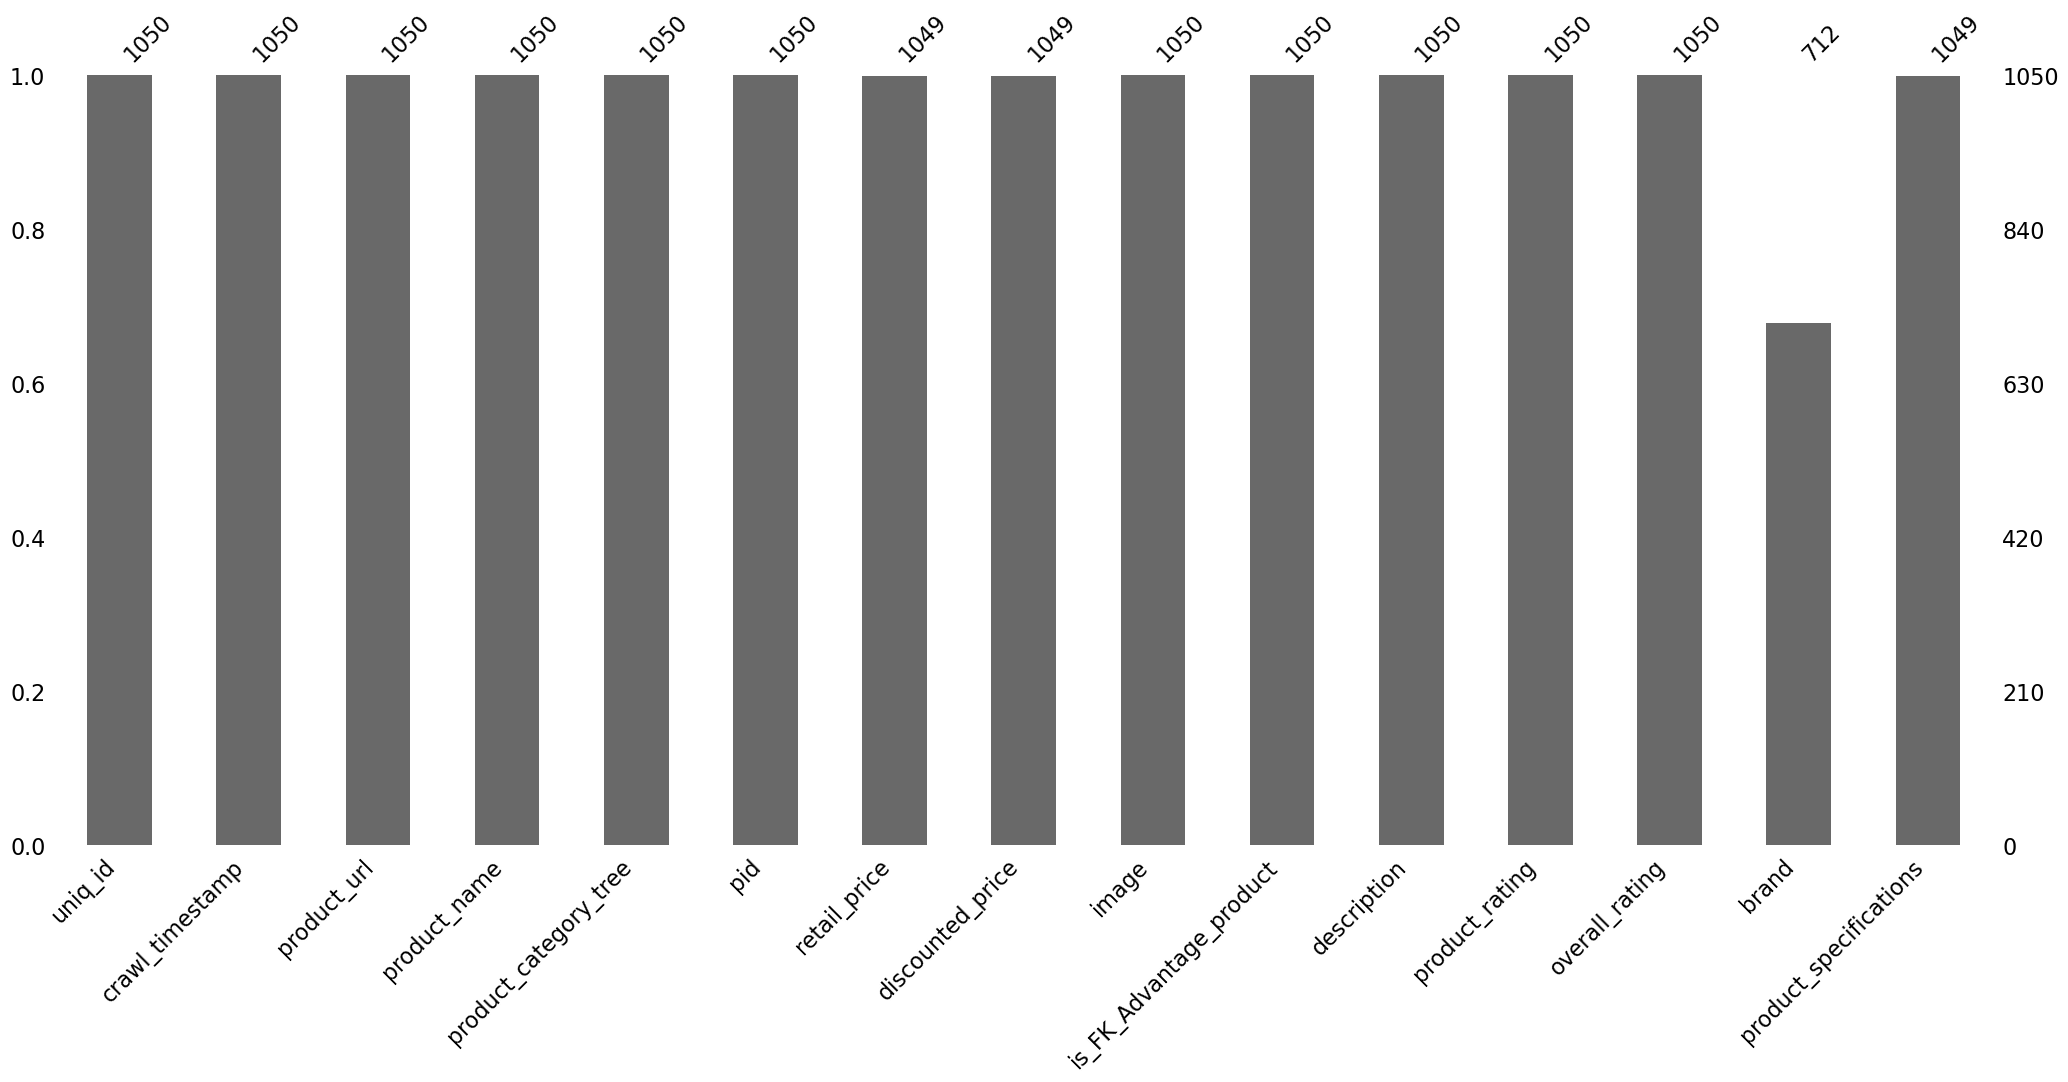

In [4]:
# Affichage d'un barplot des valeurs manquantes
msno.bar(df)

# Analyse de la variable product_category_tree

La colonne product_category_tree contient la hiérarchie des catégories de produits dans le dataset. Chaque entrée de cette colonne est une chaîne de caractères qui représente la structure des catégories auxquelles un produit appartient. Les catégories sont séparées par l'opérateur >> et sont organisées selon un ordre hiérarchique allant de la catégorie la plus générale à la plus spécifique.

Par exemple :

Une entrée comme "Home >> Linge >> Draps" indique que le produit appartient à la catégorie "Draps", qui est un sous-ensemble de "Linge", lui-même une sous-catégorie de "Home".

Cette hiérarchisation permet de structurer les produits de manière logique, facilitant ainsi la recherche et la classification sur la plateforme de vente. Cependant, pour des analyses plus approfondies ou pour une utilisation automatisée, il peut être utile de démanteler cette hiérarchie en plusieurs niveaux, chacun représentant une catégorie spécifique du produit.

In [5]:
# On nettoie la chaîne pour retirer les crochets et guillemets
cleaned_categories = df['product_category_tree'].str.strip("[]").str.replace("'", "").str.replace('"', '')

# On compte le nombre de niveaux en comptant le nombre de séparateurs ">>" + 1
df['nb_niveaux'] = cleaned_categories.str.count('>>') + 1

# Afficher la distribution du nombre de niveaux
df['nb_niveaux'].value_counts().sort_index()

nb_niveaux
2      3
3    368
4    274
5    278
6     70
7     57
Name: count, dtype: int64

Afin de mieux comprendre la structure hiérarchique des catégories de produits, nous avons extrait le nombre de niveaux présents dans chaque entrée de la colonne product_category_tree. Chaque niveau correspond à une sous-catégorie, séparée par l’opérateur >>.

L’analyse révèle que le nombre de niveaux varie de 2 à 7 selon les produits.

Afin d’analyser plus finement la variable product_category_tree, nous allons la décomposer en plusieurs colonnes distinctes, chacune correspondant à un niveau hiérarchique de la catégorie. Cette transformation nous permettra d’étudier les catégories principales, secondaires, etc., séparément, de repérer plus facilement les tendances, et de préparer les données pour une éventuelle classification automatique.

Concrètement, une nouvelle colonne sera créée pour chaque niveau hiérarchique identifié, de la plus générale (niveau 0) à la plus spécifique (niveau N), en tenant compte du nombre maximum de niveaux observés dans le dataset.

In [6]:
# Nettoyage de la colonne pour extraire la structure hiérarchique proprement
df['categorie_propre'] = df['product_category_tree'].str.extract(r'\["(.+?)"\]')

# On sépare les catégories hiérarchiques
categories_sep = df['categorie_propre'].str.split('>>', expand=True)

# On renomme les colonnes par niveau 
categories_sep.columns = [f"niveau_categorie_{i+1}" for i in range(categories_sep.shape[1])]

# On concatène au dataframe d'origine
df = pd.concat([df, categories_sep], axis=1)

# Suppression des colonnes temporaires
df.drop(columns=['nb_niveaux', 'categorie_propre'], inplace=True, errors='ignore')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [7]:
# Analyser le nombre de valeurs manquantes et le nombre de catégories distinctes pour chaque colonne de niveau
missing_values = df[['niveau_categorie_1', 'niveau_categorie_2', 'niveau_categorie_3', 
                     'niveau_categorie_4', 'niveau_categorie_5', 'niveau_categorie_6', 
                     'niveau_categorie_7']].isnull().sum()

distinct_categories = df[['niveau_categorie_1', 'niveau_categorie_2', 'niveau_categorie_3', 
                          'niveau_categorie_4', 'niveau_categorie_5', 'niveau_categorie_6', 
                          'niveau_categorie_7']].nunique()

print("Valeurs manquantes par colonne :")
print(missing_values)
print("\nNombre de catégories distinctes par colonne :")
print(distinct_categories)

Valeurs manquantes par colonne :
niveau_categorie_1      0
niveau_categorie_2      0
niveau_categorie_3      3
niveau_categorie_4    371
niveau_categorie_5    645
niveau_categorie_6    923
niveau_categorie_7    993
dtype: int64

Nombre de catégories distinctes par colonne :
niveau_categorie_1      7
niveau_categorie_2     63
niveau_categorie_3    246
niveau_categorie_4    350
niveau_categorie_5    297
niveau_categorie_6    117
niveau_categorie_7     57
dtype: int64


Nous avons choisi de conserver uniquement la colonne niveau_categorie_1 car elle ne contient aucune valeur manquante et présente un nombre raisonnable de catégories distinctes (7). Cette simplicité garantit une meilleure qualité des données pour l’analyse et facilite l’interprétation, contrairement aux niveaux plus profonds qui comportent de nombreuses valeurs manquantes et une grande diversité de catégories, rendant l’analyse plus complexe et moins robuste.

In [8]:
# On sélectionne uniquement les colonnes d'intérêt
df_reduit = df[['description', 'niveau_categorie_1']].copy()

# Affichage des premières lignes pour vérification
df_reduit.head()

,description,niveau_categorie_1
0,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


#  Application de DistilBERT
Nous utilisons DistilBERT pour extraire des caractéristiques (embeddings) à partir des textes. Ces représentations vectorielles capturent le sens et le contexte des descriptions produits.

À partir de ces embeddings, nous explorons deux approches :

- Clustering non supervisé : nous appliquons l’algorithme K-means pour regrouper les produits selon la similarité de leurs descriptions.

- Classification supervisée : nous utilisons les embeddings comme variables d’entrée pour entraîner un modèle de classification visant à prédire la catégorie de chaque produit.

Cette démarche permet d’exploiter la puissance de BERT pour transformer le texte en données exploitables par des algorithmes classiques de machine learning.

## Prétraitement des données
Le prétraitement des données textuelles est une étape importante avant d’utiliser DistilBERT.
Son but est de nettoyer et préparer les descriptions produits pour que le modèle puisse bien comprendre le texte.

Voici les traitements que nous appliquons :

- Nettoyage simple : on enlève les éléments inutiles comme les caractères spéciaux.

- Gestion des majuscules/minuscules :  Nous utilisons le modèle distilbert-base-uncased, qui a été pré-entraîné sur du texte en minuscules. Par conséquent, toutes les descriptions produits sont converties en minuscules avant l’extraction des embeddings.

- Pas de suppression des mots fréquents (stopwords) ni de modification des mots (comme la lemmatisation), car DistilBERT comprend mieux le texte quand il est naturel.

La tokenisation, spécifique au modèle DistilBERT, sera réalisée lors de l’extraction des embeddings dans la section suivante.

Cette préparation garantit que DistilBERT reçoit des textes propres et bien formatés, ce qui facilite l’extraction des informations importantes.

In [9]:
def pretraiter_texte(texte):
    """
    Nettoie et prépare le texte pour l'encodage avec DistilBERT-uncased.
    - Met en minuscules
    - Supprime les caractères spéciaux inutiles

    Args:
        texte (str): Texte brut à nettoyer

    Returns:
        str: Texte prétraité
    """
    # Mettre en minuscules
    texte = texte.lower()
    # Supprimer les caractères spéciaux 
    texte = re.sub(r"[^a-z0-9\s]", " ", texte)
    # Supprimer les espaces multiples
    texte = re.sub(r"\s+", " ", texte).strip()
    return texte

# Application sur le DataFrame réduit
df_reduit['description_pretraitee'] = df_reduit['description'].astype(str).apply(pretraiter_texte)

In [10]:
# Affiche toutes les colonnes sans troncature des textes
pd.set_option('display.max_colwidth', None)
df_reduit.head()

,description,niveau_categorie_1,description_pretraitee
0,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",Home Furnishing,key features of elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain 213 cm in height pack of 2 price rs 899 this curtain enhances the look of the interiors this curtain is made from 100 high quality polyester fabric it features an eyelet style stitch with metal ring it makes the room environment romantic and loving this curtain is ant wrinkle and anti shrinkage and have elegant apparance give your home a bright and modernistic appeal with these designs the surreal attention is sure to steal hearts these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening you create the most special moments of joyous beauty given by the soothing prints bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight specifications of elegance polyester multicolor abstract eyelet door curtain 213 cm in height pack of 2 general brand elegance designed for door type eyelet model name abstract polyester door curtain set of 2 model id duster25 color multicolor dimensions length 213 cm in the box number of contents in sales package pack of 2 sales package 2 curtains body design material polyester
1,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",Baby Care,specifications of sathiyas cotton bath towel 3 bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm 500 model name sathiyas cotton bath towel ideal for men women boys girls model id asvtwl322 color red yellow blue size mediam dimensions length 30 inch width 60 inch in the box number of contents in sales package 3 sales package 3 bath towel
2,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exc

Le prétraitement appliqué est conforme aux recommandations pour l’utilisation de DistilBERT : conversion en minuscules, nettoyage léger, conservation des chiffres et suppression minimale des caractères non textuels. Cela garantit que le texte reste proche de celui utilisé lors du pré-entraînement du modèle, optimisant ainsi la qualité des embeddings extraits.

## Extraction des caractéristiques avec DistilBERT
L’extraction des caractéristiques textuelles est une étape clé pour transformer les descriptions produits en données numériques exploitables par des algorithmes de machine learning. Nous utilisons le modèle DistilBERT, une version allégée de BERT, pour générer des embeddings vectoriels qui capturent la signification et le contexte des textes.

DistilBERT offre un excellent compromis entre rapidité, efficacité et performance. Sa taille réduite et sa vitesse d’exécution facilitent la comparaison de méthodes sur un environnement standard, tout en maintenant une qualité d’embeddings proche de celle de BERT. Ce choix est particulièrement adapté à notre objectif : comparer des techniques récentes de traitement automatique du langage sur un pipeline reproductible, sans viser l’optimisation extrême des performances.

Ces représentations vectorielles denses permettent de modéliser efficacement les similarités sémantiques entre produits et servent de base pour les étapes suivantes de clustering et de classification supervisée. Les embeddings produits par BERT ou DistilBERT sont aujourd’hui une référence dans le domaine du NLP pour extraire le sens des textes et améliorer la qualité des analyses subséquentes.

In [11]:
def extraire_embeddings_distilbert(
    df_text, 
    colonne_texte='description_pretraitee', 
    colonne_cible='niveau_categorie_1', 
    nom_modele='distilbert-base-uncased', 
    longueur_max=512
):
    """
    Encode chaque texte d'un DataFrame en embeddings DistilBERT et retourne un nouveau DataFrame
    avec les embeddings et la colonne cible.

    Args:
        df_text (pd.DataFrame): DataFrame contenant les textes et la cible.
        colonne_texte (str): nom de la colonne texte à encoder.
        colonne_cible (str): nom de la colonne cible.
        nom_modele (str): nom du modèle DistilBERT à utiliser.
        longueur_max (int): longueur maximale des séquences tokenisées.

    Returns:
        pd.DataFrame: DataFrame avec les colonnes des embeddings + colonne cible.
    """
    # Charger le tokenizer et le modèle DistilBERT
    tokenizer = AutoTokenizer.from_pretrained(nom_modele)
    modele = AutoModel.from_pretrained(nom_modele)
    modele.eval()  # Mode évaluation

    embeddings = []
    for texte in tqdm(df_text[colonne_texte], desc="Encodage DistilBERT"):
        # Tokenisation et encodage
        entrees = tokenizer(
            texte, 
            return_tensors='pt', 
            truncation=True, 
            padding='max_length', 
            max_length=longueur_max
        )
        with torch.no_grad():
            sorties = modele(**entrees)
            # On prend le vecteur [CLS] (premier token) comme représentation globale du texte
            cls_embedding = sorties.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)
    X_bert = np.vstack(embeddings)

    # Création du DataFrame final
    noms_colonnes = [f'distilbert_{i}' for i in range(X_bert.shape[1])]
    df_bert = pd.DataFrame(X_bert, columns=noms_colonnes)
    df_bert[colonne_cible] = df_text[colonne_cible].values
    return df_bert

In [12]:
df_bert = extraire_embeddings_distilbert(df_reduit)
df_bert.head()

Encodage DistilBERT:   0%|          | 0/1050 [00:00<?, ?it/s]

,distilbert_0,distilbert_1,distilbert_2,distilbert_3,distilbert_4,distilbert_5,distilbert_6,distilbert_7,distilbert_8,distilbert_9,...,distilbert_759,distilbert_760,distilbert_761,distilbert_762,distilbert_763,distilbert_764,distilbert_765,distilbert_766,distilbert_767,niveau_categorie_1
0,-0.073555,-0.220791,0.129954,-0.031435,0.268531,-0.214480,0.125507,0.270609,-0.428540,-0.174855,...,-0.558391,0.276934,-0.188139,0.030704,0.084891,-0.108547,-0.259566,0.437567,-0.173840,Home Furnishing
1,-0.266259,-0.262224,0.071941,-0.015313,-0.007887,-0.084493,0.159397,0.030701,-0.201446,-0.038073,...,-0.408105,0.114138,-0.232988,0.076115,-0.113973,-0.126613,-0.295599,0.124616,0.130533,Baby Care
2,-0.128352,-0.121166,0.059365,-0.007976,0.079259,-0.144679,0.088371,0.281075,-0.247890,-0.081484,...,-0.522771,0.080443,-0.058410,0.069727,0.129165,-0.223674,-0.284805,0.275614,-0.021307,Baby Care
3,-0.184090,-0.228507,-0.256097,-0.170536,0.224655,-0.077462,0.093144,0.226689,-0.245227,-0.027251,...,-0.405140,0.143474,-0.117900,0.195964,-0.027669,-0.193492,-0.221446,0.330242,-0.000181,Home Furnishing
4,-0.206019,-0.206288,-0.188074,-0.146527,0.186783,-0.152474,0.152171,0.358969,-0.135706,-0.160813,...,-0.451656,0.239228,-0.085404,0.188507,0.100569,-0.203946,-0.130624,0.361054,-0.104527,Home Furnishing


## Réduction de dimension avec ACP 

Les embeddings générés par DistilBERT sont des vecteurs de grande dimension (768 dimensions), ce qui peut poser plusieurs problèmes lors de l’application d’algorithmes de clustering.
En effet, la présence d’un grand nombre de dimensions rend les calculs plus coûteux, peut introduire du bruit et rendre les distances entre points moins significatives, un phénomène connu sous le nom de “malédiction de la dimensionnalité”.

Pour pallier ces difficultés, nous appliquons une Analyse en Composantes Principales (ACP) avant le clustering.
Cette méthode permet de :

- Réduire le nombre de dimensions tout en conservant l’essentiel de l’information,

- Limiter le bruit et les redondances dans les données,

- Améliorer la qualité et la stabilité du clustering en rendant les distances plus pertinentes,

- Accélérer les calculs et réduire la mémoire nécessaire.

En résumé, l’ACP est une étape indispensable pour préparer efficacement les embeddings textuels à une analyse de regroupement, en assurant de meilleures performances et une interprétation plus fiable des résultats.

In [13]:
# 1.Séparation des features et de la cible
X = df_bert.drop(columns=['niveau_categorie_1']).values
y = df_bert['niveau_categorie_1'].values

# 2. Ajustement initial de la PCA pour déterminer le nombre de composantes à garder
pca = PCA().fit(X)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
print(f"Nombre de composantes pour expliquer 99% de la variance : {n_components_99}")

Nombre de composantes pour expliquer 99% de la variance : 257


In [14]:
# 3. Création et application de la PCA finale avec le bon nombre de composantes
pca_final = PCA(n_components=n_components_99)
X_pca = pca_final.fit_transform(X)

## Visualisation avec t_sne

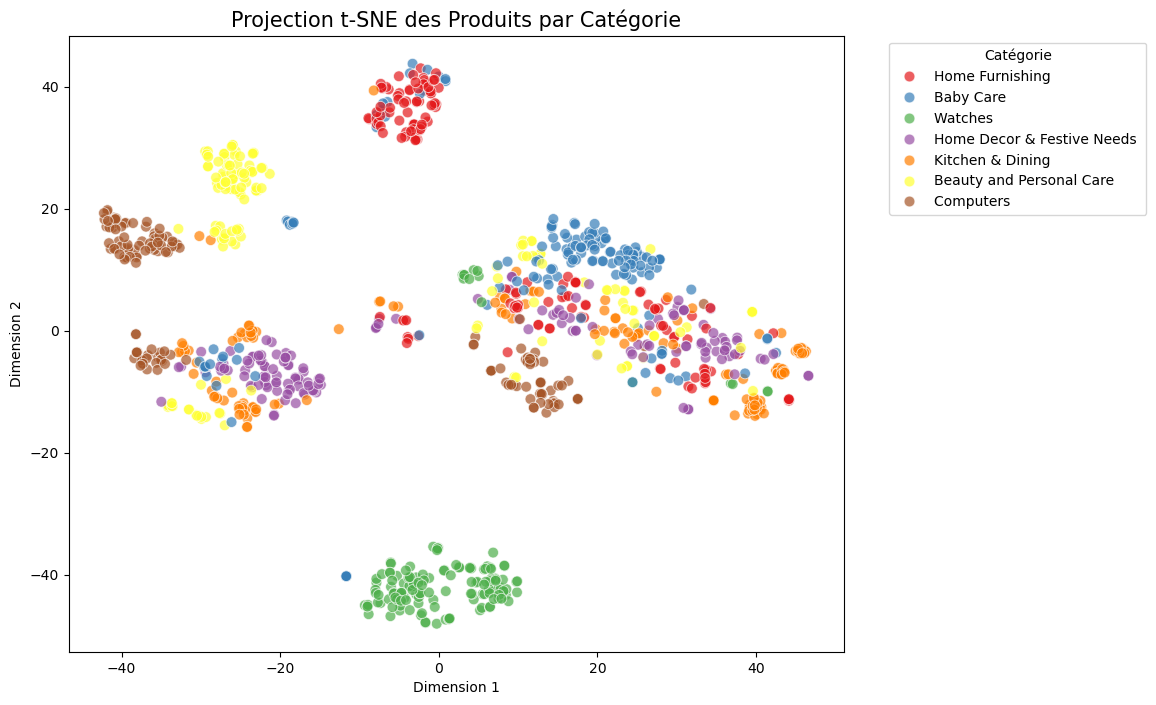

In [15]:
# 1. Initialisation de t-SNE pour réduire à 2 dimensions (idéal pour la visualisation)
tsne = TSNE(n_components=2, random_state=42)

# 2. Application de t-SNE sur les données déjà réduites par PCA (X_pca)
# Cela permet d'accélérer le calcul et d'obtenir une meilleure visualisation
X_tsne = tsne.fit_transform(X_pca)

# 3. Création d'un DataFrame pour faciliter la visualisation avec seaborn
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE-1', 'TSNE-2'])
df_tsne['niveau_categorie_1'] = y  # Ajout de la colonne cible pour la couleur

# 4. Visualisation avec seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_tsne, 
    x='TSNE-1', 
    y='TSNE-2', 
    hue='niveau_categorie_1', 
    palette='Set1', 
    s=60, 
    alpha=0.7
)
plt.title('Projection t-SNE des Produits par Catégorie', fontsize=15)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Catégorie', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

La projection t-SNE montre que les produits de certaines catégories se regroupent bien, tandis que d’autres sont plus mélangés. Cela suggère que, pour certaines catégories, le contenu textuel est suffisamment distinct pour permettre un regroupement automatique, mais que d’autres catégories partagent des descriptions similaires. 

## Application de K-Means 

Afin d’identifier automatiquement des groupes de produits similaires à partir des embeddings textuels, nous appliquons l’algorithme de K-Means sur les données réduites par ACP.
Dans cette étude, nous choisissons de former 7 clusters, ce qui permettra d’explorer la correspondance entre ces groupes non supervisés et les catégories connues des articles.

In [16]:
# 1. Détermination du nombre de clusters (égal au nombre de vraies catégories)
n_clusters = len(df_bert['niveau_categorie_1'].unique())

# 2. Application de K-Means sur les données réduites par PCA
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_pred = kmeans.fit_predict(X_pca)

# 3. Évaluation du clustering par rapport aux vraies catégories
print("Homogeneity Score :", round(metrics.homogeneity_score(y, y_pred), 3))
print("Completeness Score :", round(metrics.completeness_score(y, y_pred), 3))
print("V-measure :", round(metrics.v_measure_score(y, y_pred), 3))
print("Adjusted Rand Index :", round(metrics.adjusted_rand_score(y, y_pred), 3))

# 4. Silhouette Score
print("Silhouette Score :", round(metrics.silhouette_score(X_pca, y_pred), 3))

Homogeneity Score : 0.288
Completeness Score : 0.334
V-measure : 0.31
Adjusted Rand Index : 0.173
Silhouette Score : 0.161


C:\Users\joan6\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


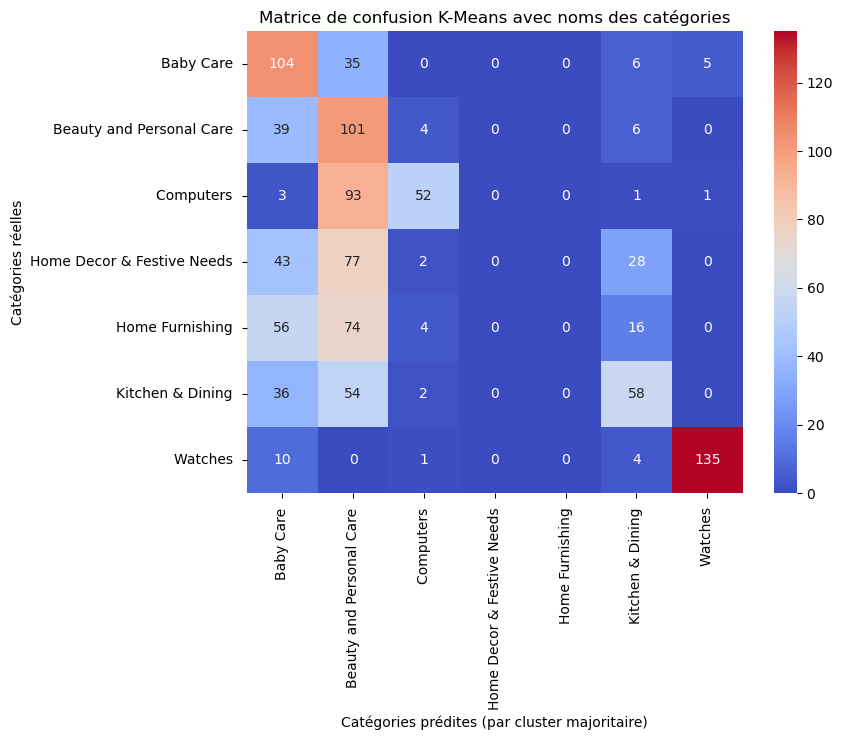

In [17]:
# 1. Création d'un DataFrame associant la vraie catégorie et le cluster prédit pour chaque article
df_clusters = pd.DataFrame({'vraie_classe': y, 'cluster': y_pred})

# 2. Pour chaque cluster, on trouve la catégorie réelle la plus représentée (majoritaire)
# Cela permet d'associer chaque cluster à la catégorie qu'il regroupe le plus souvent
cluster_to_class = df_clusters.groupby('cluster')['vraie_classe'] \
    .agg(lambda x: x.value_counts().idxmax()).to_dict()

# 3. On remplace chaque numéro de cluster par le nom de la catégorie majoritaire correspondante
y_pred_remapped = np.array([cluster_to_class[c] for c in y_pred])

# 4. On crée une liste ordonnée des catégories réelles pour afficher correctement la matrice
categories = sorted(np.unique(y))

# 5. Calcul de la matrice de confusion entre vraies catégories et catégories prédites (remappées)
cm = confusion_matrix(y, y_pred_remapped, labels=categories)

# 6. Affichage de la matrice de confusion avec seaborn, avec les noms des catégories sur les axes
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm",
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Catégories prédites (par cluster majoritaire)')
plt.ylabel('Catégories réelles')
plt.title('Matrice de confusion K-Means avec noms des catégories')
plt.show()

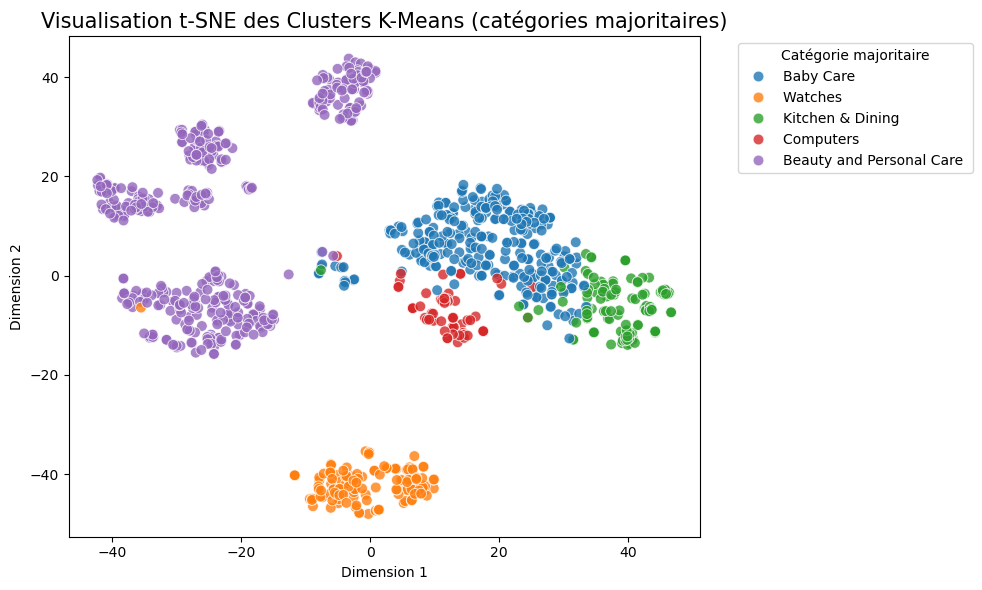

In [18]:
# 1. Application de t-SNE sur les données réduites par PCA
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# 2. Création d'un DataFrame pour la visualisation
df_viz = pd.DataFrame(X_tsne, columns=['TSNE-1', 'TSNE-2'])
df_viz['Catégorie majoritaire'] = y_pred_remapped  # Noms des catégories majoritaires

# 3. Visualisation avec seaborn
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_viz,
    x='TSNE-1',
    y='TSNE-2',
    hue='Catégorie majoritaire',
    palette='tab10',
    s=60,
    alpha=0.8
)
plt.title('Visualisation t-SNE des Clusters K-Means (catégories majoritaires)', fontsize=15)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Catégorie majoritaire', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Classification supervisée 

Après avoir exploré la structure des données par des méthodes non supervisées, nous abordons maintenant la classification supervisée. L’objectif est de prédire automatiquement la catégorie d’un article à partir de sa description textuelle, en s’appuyant sur les représentations vectorielles issues de BERT.

Pour cette tâche, nous choisissons d’utiliser une régression logistique (Logistic Regression). Ce modèle est particulièrement adapté à la classification multiclasse sur des données vectorielles de taille raisonnable, comme les embeddings DistilBERT.
La régression logistique présente plusieurs avantages :

- Simplicité et rapidité d’entraînement

- Facilité d’interprétation des résultats

- Bonne performance sur ce type de données sans nécessiter de réglages complexes

Ce choix permet d’obtenir rapidement une première évaluation de la difficulté de la tâche et de la qualité des embeddings pour la classification.

### Séparation en train/test

Avant d’entraîner et d’évaluer notre modèle de classification, il est essentiel de diviser notre jeu de données en deux parties distinctes : un ensemble d’entraînement (train) et un ensemble de test.
Cette séparation permet d’entraîner le modèle sur une partie des données tout en réservant l’autre partie pour évaluer objectivement ses performances sur des exemples jamais vus.
Cela garantit que les résultats obtenus reflètent la capacité du modèle à généraliser à de nouvelles descriptions d’articles.

La séparation du jeu de données en ensembles d’entraînement et de test est réalisée de façon stratifiée.
Cela signifie que la proportion des différentes catégories est préservée dans chaque sous-ensemble, tout comme dans le jeu de données initial.
Cette approche est particulièrement importante en classification, notamment lorsque certaines classes sont minoritaires ou que la distribution des classes est déséquilibrée.
Le fait de stratifier garantit que le modèle sera entraîné et évalué sur des ensembles représentatifs de la distribution réelle des catégories, ce qui permet d’obtenir une évaluation plus fiable et réaliste de ses performances.

Pour la classification supervisée, nous utilisons directement les embeddings BERT d’origine (X). En effet, la réduction de dimensionnalité par PCA, bien qu’utile pour la visualisation ou le clustering, peut entraîner une perte d’informations discriminantes pour la classification, car elle ne tient pas compte des labels lors de la transformation. Les modèles supervisés sont généralement capables de traiter efficacement les embeddings de BERT sans réduction préalable. 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X,                  # Les embeddings BERT d'origine
    y,                  # Les labels de catégories
    test_size=0.2,      # 20% des données pour le test, 80% pour l'entraînement
    random_state=42,    # Pour la reproductibilité
    stratify=y          # Pour conserver la distribution des classes dans chaque sous-ensemble
)

### Entraînement et évaluation du modèle de classification supervisée

Après avoir préparé les données et réalisé la séparation en ensembles d’entraînement et de test, nous procédons à l’entraînement du modèle de classification supervisée, ici une régression logistique.

L’objectif est d’apprendre à prédire la catégorie d’un article à partir de ses embeddings DistilBERT, puis d’évaluer la performance du modèle sur des données jamais vues afin de mesurer sa capacité de généralisation.

Nous utiliserons des métriques classiques telles que la précision, le rappel, la F-mesure, ainsi que la matrice de confusion pour analyser en détail les résultats obtenus.

Accuracy sur l'ensemble d'entraînement : 0.9798
Accuracy sur l'ensemble de test : 0.9095

Rapport de classification (test) :
                             precision    recall  f1-score   support

                 Baby Care        0.81      0.87      0.84        30
  Beauty and Personal Care        0.93      0.87      0.90        30
                 Computers        1.00      1.00      1.00        30
Home Decor & Festive Needs        0.81      0.87      0.84        30
           Home Furnishing        0.87      0.90      0.89        30
          Kitchen & Dining        0.96      0.87      0.91        30
                   Watches        1.00      1.00      1.00        30

                   accuracy                           0.91       210
                  macro avg       0.91      0.91      0.91       210
               weighted avg       0.91      0.91      0.91       210



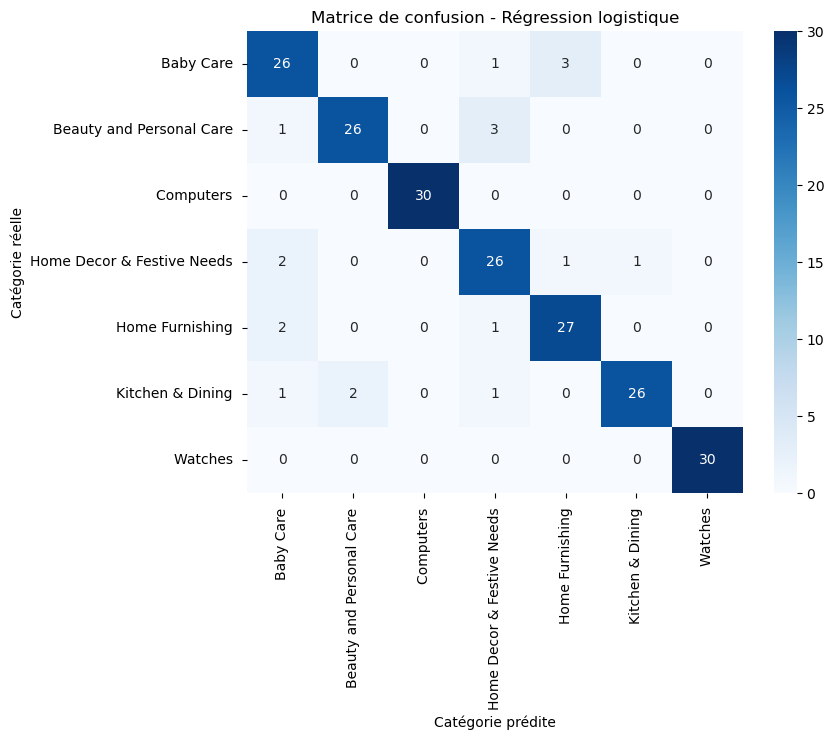

In [20]:
# 1. Entraînement du modèle
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# 2. Prédictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# 3. Calcul des accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Accuracy sur l'ensemble d'entraînement : {train_accuracy:.4f}")
print(f"Accuracy sur l'ensemble de test : {test_accuracy:.4f}")

# 4. Rapport de classification sur test
print("\nRapport de classification (test) :")
print(classification_report(y_test, y_test_pred))

# 5. Matrice de confusion sur test
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Catégorie prédite')
plt.ylabel('Catégorie réelle')
plt.title('Matrice de confusion - Régression logistique')
plt.show()

La régression logistique appliquée aux embeddings DistilBERT permet d’obtenir une classification précise et robuste des descriptions d’articles. Avec une accuracy de 97,98 % sur l’ensemble d’entraînement et de 90,95 % sur l’ensemble de test, le modèle montre une très bonne capacité de généralisation, sans signe notable de surapprentissage. Les scores élevés de précision, rappel et F1-score pour l’ensemble des catégories confirment la qualité des représentations textuelles et l’efficacité de la méthode supervisée choisie.

# Application de DeBERTa


Après avoir exploité BERT pour l’extraction de caractéristiques à partir des descriptions d’articles, nous appliquons ici une technique plus récente et reconnue comme étant à la pointe de l’état de l’art : **DeBERTa** (Decoding-enhanced BERT with Disentangled Attention). Ce modèle, disponible via la bibliothèque Hugging Face ([documentation officielle](https://huggingface.co/docs/transformers/model_doc/deberta)), permet de générer facilement des embeddings textuels de haute qualité.

Développé par Microsoft Research et publié en 2020, DeBERTa introduit plusieurs innovations majeures dans la manière de représenter le langage :

- **Attention disentangled** : DeBERTa dissocie explicitement l'information liée au contenu (le mot) de celle liée à la position (l’ordre dans la phrase) lors du calcul des représentations. Cette séparation permet de mieux capturer les relations syntaxiques et sémantiques entre les mots.

- **Pré-entraînement optimisé** : Grâce à des techniques d’apprentissage plus avancées que celles utilisées dans BERT (et DistilBERT), DeBERTa génère des embeddings plus riches, mieux structurés et plus informatifs.

Dans cette section, nous utilisons DeBERTa pour extraire les embeddings des descriptions d’articles, que nous exploiterons ensuite dans une tâche de classification supervisée.

L’objectif est de comparer la qualité de ces représentations à celles issues de BERT, afin d’évaluer dans quelle mesure les innovations apportées par DeBERTa améliorent la performance du modèle de classification.


Pour plus de détails sur l’architecture et les innovations de DeBERTa, voir l’article original sur arXiv : https://arxiv.org/abs/2006.03654

## Prétraitement des données

Le prétraitement des données textuelles avant l’utilisation de DeBERTa dépend du type de modèle choisi :

- Si le modèle DeBERTa est “cased” (la majorité des modèles standards, comme deberta-base) :
→ On conserve la casse d’origine du texte (pas de conversion en minuscules). C'est ce que nous allons utiliser ici.

- Si le modèle DeBERTa est “uncased” :
→ On convertit tous les textes en minuscules avant la tokenisation, pour correspondre au pré-entraînement du modèle.

Dans les deux cas, le reste du prétraitement reste identique :

- Seule étape utile : suppression des espaces multiples (et éventuellement des balises HTML si elles existent dans les données).

- Pas de suppression des mots fréquents (stopwords) ni de lemmatisation, afin de conserver le texte dans sa forme naturelle.

La tokenisation spécifique à DeBERTa sera réalisée lors de l’extraction des embeddings dans la section suivante.

Ce prétraitement garantit que DeBERTa reçoit des textes propres et bien formatés, adaptés à la configuration du modèle utilisé.

In [21]:
# On sélectionne uniquement les colonnes d'intérêt
df_reduit_deberta = df[['description', 'niveau_categorie_1']].copy()

# Affichage des premières lignes pour vérification
df_reduit_deberta.head(2)

,description,niveau_categorie_1
0,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",Home Furnishing
1,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",Baby Care


In [22]:
def pretraiter_texte_deberta(texte):
    """
    Prépare le texte pour l'encodage avec deberta-base (anglais, cased).
    - Nettoie simplement les espaces multiples

    Args:
        texte (str): Texte brut à nettoyer

    Returns:
        str: Texte prétraité
    """
    # Supprimer les espaces multiples
    texte = re.sub(r"\s+", " ", texte).strip()
    return texte

# Application sur le DataFrame réduit
df_reduit_deberta['description_pretraitee'] = df_reduit_deberta['description'].astype(str).apply(pretraiter_texte_deberta)
df_reduit_deberta.head(2)

,description,niveau_categorie_1,description_pretraitee
0,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",Home Furnishing,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester"
1,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",Baby Care,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel"


## Extraction des caractéristiques avec DeBERTa

In [23]:
def extraire_embeddings_deberta(
    df_text, 
    colonne_texte='description_pretraitee', 
    colonne_cible='niveau_categorie_1', 
    nom_modele='microsoft/deberta-v3-base', 
    longueur_max=512
):
    """
    Encode chaque texte d'un DataFrame en embeddings DeBERTa et retourne un nouveau DataFrame
    avec les embeddings concaténés et la colonne cible.

    Args:
        df_text (pd.DataFrame): DataFrame contenant les textes et la cible.
        colonne_texte (str): Nom de la colonne contenant le texte à encoder.
        colonne_cible (str): Nom de la colonne contenant la variable cible.
        nom_modele (str): Nom du modèle DeBERTa à utiliser (par défaut : 'microsoft/deberta-base').
        longueur_max (int): Longueur maximale des séquences tokenisées.

    Returns:
        pd.DataFrame: DataFrame contenant les embeddings et la colonne cible.
    """

    # 1. Charger le tokenizer et le modèle pré-entraîné DeBERTa
    tokenizer = AutoTokenizer.from_pretrained(nom_modele)
    modele = AutoModel.from_pretrained(nom_modele)
    modele.eval()  # On désactive le dropout et autres couches de training

    embeddings = []

    # 2. Boucle sur chaque texte pour encoder avec DeBERTa
    for texte in tqdm(df_text[colonne_texte], desc="Encodage DeBERTa"):
        # Tokenisation
        entrees = tokenizer(
            texte,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=longueur_max
        )

        # 3. Passage dans le modèle sans calcul de gradient
        with torch.no_grad():
            sorties = modele(**entrees)

            # 4. Extraction du vecteur [CLS] comme représentation globale du texte
            cls_embedding = sorties.last_hidden_state[:, 0, :].squeeze().numpy()

        embeddings.append(cls_embedding)

    # 5. Conversion en tableau numpy
    X_deberta = np.vstack(embeddings)

    # 6. Création du DataFrame final avec noms de colonnes explicites
    noms_colonnes = [f'deberta_{i}' for i in range(X_deberta.shape[1])]
    df_deberta = pd.DataFrame(X_deberta, columns=noms_colonnes)

    # 7. Ajout de la colonne cible
    df_deberta[colonne_cible] = df_text[colonne_cible].values

    return df_deberta

In [24]:
df_deberta = extraire_embeddings_deberta(df_reduit_deberta)
df_deberta.head()

C:\Users\joan6\anaconda3\Lib\site-packages\transformers\convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

C:\Users\joan6\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\joan6\.cache\huggingface\hub\models--microsoft--deberta-v3-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Encodage DeBERTa:   0%|          | 0/1050 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

,deberta_0,deberta_1,deberta_2,deberta_3,deberta_4,deberta_5,deberta_6,deberta_7,deberta_8,deberta_9,...,deberta_759,deberta_760,deberta_761,deberta_762,deberta_763,deberta_764,deberta_765,deberta_766,deberta_767,niveau_categorie_1
0,0.063697,0.095997,0.037595,-0.019118,-0.001302,-0.095439,-0.017062,0.004541,0.048127,0.076103,...,-0.055618,-0.076074,-0.051800,-0.076820,-0.117648,0.062014,-0.049780,0.055530,0.040645,Home Furnishing
1,0.133188,0.181323,0.040971,-0.067981,0.028887,-0.141007,-0.009817,0.092200,-0.163984,0.098183,...,0.027172,-0.040727,-0.024478,-0.029528,-0.081913,0.026187,-0.042458,0.111162,0.030802,Baby Care
2,0.047087,0.089670,0.009647,-0.017636,-0.008707,-0.095255,-0.012320,0.010750,0.048419,0.054262,...,-0.044400,-0.083157,-0.066618,-0.075282,-0.080632,0.082612,-0.037745,0.077310,0.042153,Baby Care
3,0.090657,0.153258,0.004938,-0.056034,0.010730,-0.130156,-0.004642,0.059306,-0.042020,0.061289,...,-0.028188,-0.052497,-0.054822,-0.068529,-0.101101,0.042217,-0.049976,0.076494,0.041507,Home Furnishing
4,0.056656,0.108431,0.016068,-0.031346,-0.015560,-0.104849,-0.018595,0.015970,0.038452,0.070709,...,-0.044027,-0.075869,-0.077075,-0.080259,-0.097253,0.041722,-0.051673,0.049874,0.044323,Home Furnishing


## Réduction de dimension avec ACP 

In [25]:
# 1.Séparation des features et de la cible
X = df_deberta.drop(columns=['niveau_categorie_1']).values
y = df_deberta['niveau_categorie_1'].values

# 2. Ajustement initial de la PCA pour déterminer le nombre de composantes à garder
pca = PCA().fit(X)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
print(f"Nombre de composantes pour expliquer 99% de la variance : {n_components_99}")

Nombre de composantes pour expliquer 99% de la variance : 28


In [26]:
# 3. Création et application de la PCA finale avec le bon nombre de composantes
pca_final_deberta = PCA(n_components=n_components_99)
X_pca_deberta = pca_final_deberta.fit_transform(X)

## Visualisation avec t_sne

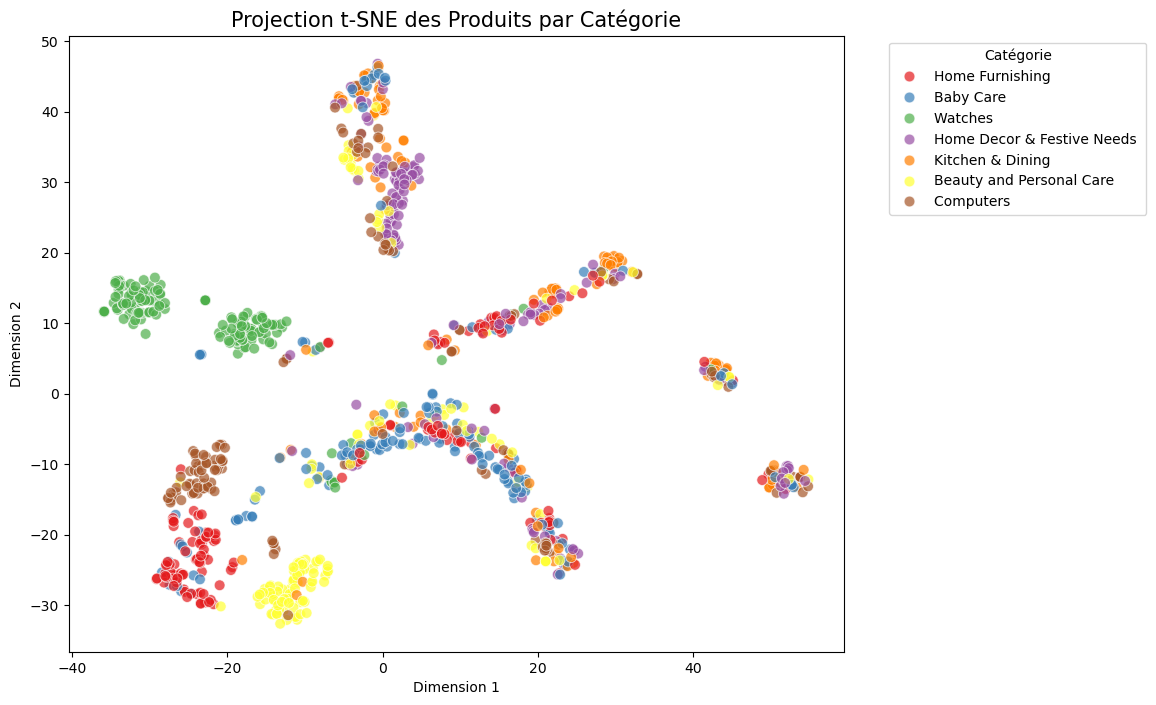

In [27]:
# 1. Initialisation de t-SNE pour réduire à 2 dimensions (idéal pour la visualisation)
tsne = TSNE(n_components=2, random_state=42)

# 2. Application de t-SNE sur les données déjà réduites par PCA (X_pca)
# Cela permet d'accélérer le calcul et d'obtenir une meilleure visualisation
X_tsne = tsne.fit_transform(X_pca_deberta)

# 3. Création d'un DataFrame pour faciliter la visualisation avec seaborn
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE-1', 'TSNE-2'])
df_tsne['niveau_categorie_1'] = y  # Ajout de la colonne cible pour la couleur

# 4. Visualisation avec seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_tsne, 
    x='TSNE-1', 
    y='TSNE-2', 
    hue='niveau_categorie_1', 
    palette='Set1', 
    s=60, 
    alpha=0.7
)
plt.title('Projection t-SNE des Produits par Catégorie', fontsize=15)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Catégorie', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Application de K-Means 

In [28]:
# 1. Détermination du nombre de clusters (égal au nombre de vraies catégories)
n_clusters = len(df_deberta['niveau_categorie_1'].unique())

# 2. Application de K-Means sur les données réduites par PCA
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_pred = kmeans.fit_predict(X_pca_deberta)

# 3. Évaluation du clustering par rapport aux vraies catégories
print("Homogeneity Score :", round(metrics.homogeneity_score(y, y_pred), 3))
print("Completeness Score :", round(metrics.completeness_score(y, y_pred), 3))
print("V-measure :", round(metrics.v_measure_score(y, y_pred), 3))
print("Adjusted Rand Index :", round(metrics.adjusted_rand_score(y, y_pred), 3))

# 4. Silhouette Score
print("Silhouette Score :", round(metrics.silhouette_score(X_pca_deberta, y_pred), 3))

Homogeneity Score : 0.182
Completeness Score : 0.201
V-measure : 0.191
Adjusted Rand Index : 0.144
Silhouette Score : 0.313


C:\Users\joan6\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


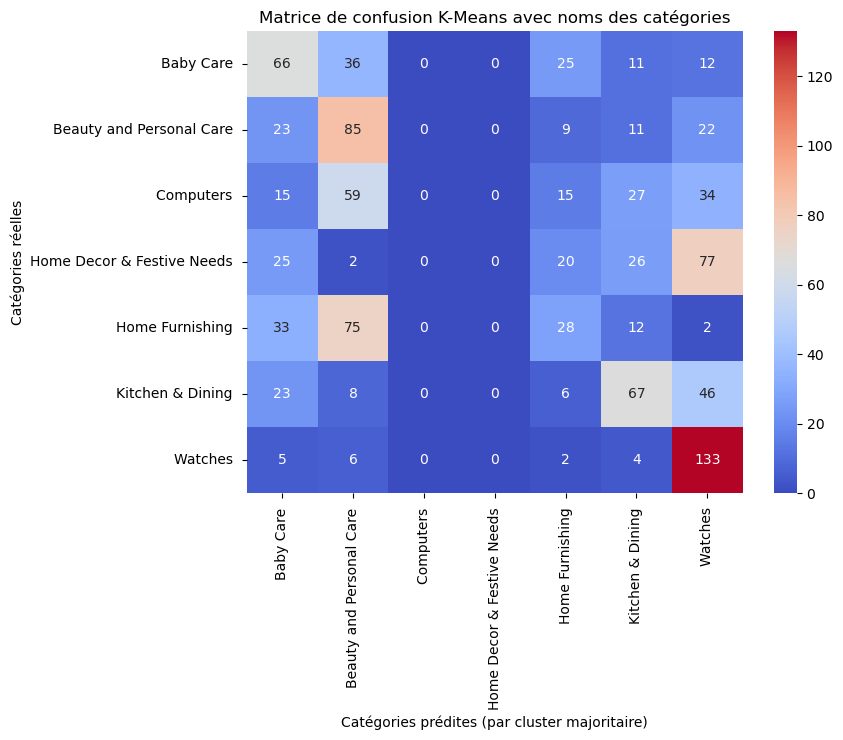

In [29]:
# 1. Création d'un DataFrame associant la vraie catégorie et le cluster prédit pour chaque article
df_clusters = pd.DataFrame({'vraie_classe': y, 'cluster': y_pred})

# 2. Pour chaque cluster, on trouve la catégorie réelle la plus représentée (majoritaire)
# Cela permet d'associer chaque cluster à la catégorie qu'il regroupe le plus souvent
cluster_to_class = df_clusters.groupby('cluster')['vraie_classe'] \
    .agg(lambda x: x.value_counts().idxmax()).to_dict()

# 3. On remplace chaque numéro de cluster par le nom de la catégorie majoritaire correspondante
y_pred_remapped = np.array([cluster_to_class[c] for c in y_pred])

# 4. On crée une liste ordonnée des catégories réelles pour afficher correctement la matrice
categories = sorted(np.unique(y))

# 5. Calcul de la matrice de confusion entre vraies catégories et catégories prédites (remappées)
cm = confusion_matrix(y, y_pred_remapped, labels=categories)

# 6. Affichage de la matrice de confusion avec seaborn, avec les noms des catégories sur les axes
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm",
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Catégories prédites (par cluster majoritaire)')
plt.ylabel('Catégories réelles')
plt.title('Matrice de confusion K-Means avec noms des catégories')
plt.show()

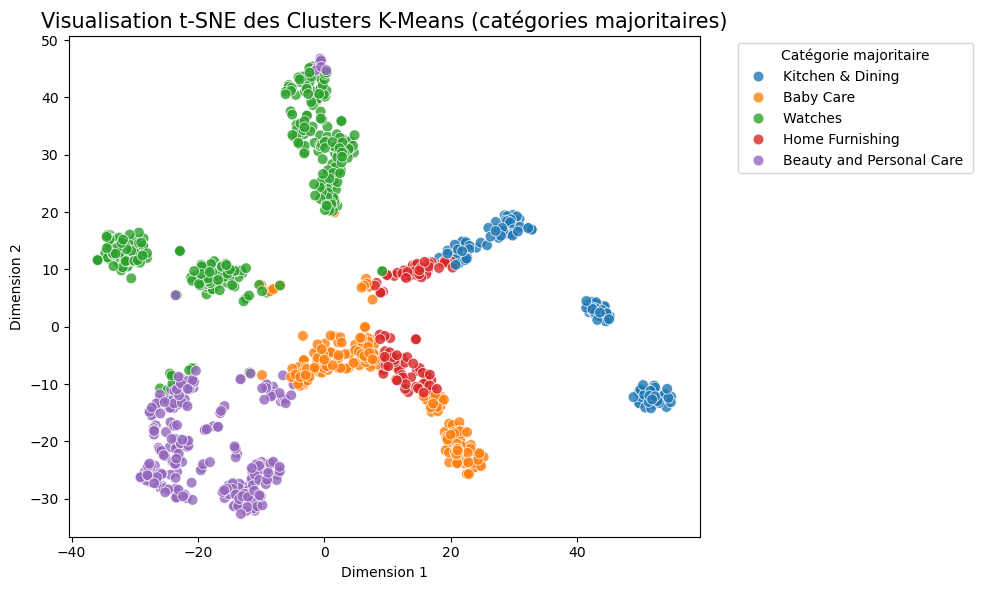

In [30]:
# 1. Application de t-SNE sur les données réduites par PCA
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca_deberta)

# 2. Création d'un DataFrame pour la visualisation
df_viz = pd.DataFrame(X_tsne, columns=['TSNE-1', 'TSNE-2'])
df_viz['Catégorie majoritaire'] = y_pred_remapped  # Noms des catégories majoritaires

# 3. Visualisation avec seaborn
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_viz,
    x='TSNE-1',
    y='TSNE-2',
    hue='Catégorie majoritaire',
    palette='tab10',
    s=60,
    alpha=0.8
)
plt.title('Visualisation t-SNE des Clusters K-Means (catégories majoritaires)', fontsize=15)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Catégorie majoritaire', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

| Modèle   | Homogeneity | Completeness | V-measure | Adjusted Rand Index | Silhouette |
|----------|-------------|--------------|-----------|---------------------|------------|
| BERT     | 0.288       | 0.334        | 0.31     | 0.173               | 0.161      |
| DeBERTa  | 0.182       | 0.201        | 0.191     | 0.144               | 0.313      |

Les résultats du clustering KMeans montrent que les embeddings BERT produisent des clusters un peu plus cohérents par rapport aux catégories réelles que ceux de DeBERTa, comme l’indiquent les scores d’homogeneity, de completeness, de V-measure et d’Adjusted Rand Index, tous supérieurs pour BERT. Cependant, DeBERTa obtient un score de silhouette plus élevé, ce qui suggère que ses clusters sont plus compacts et mieux séparés dans l’espace des embeddings, même s’ils correspondent moins bien aux vraies catégories.

## Classification supervisée 

### Séparation en train/test

In [38]:
feature_names = [f'deberta_{i}' for i in range(X.shape[1])]

X_train, X_test, y_train, y_test = train_test_split(
    X,                  # Les embeddings BERT d'origine
    y,                  # Les labels de catégories
    test_size=0.2,      # 20% des données pour le test, 80% pour l'entraînement
    random_state=42,    # Pour la reproductibilité
    stratify=y          # Pour conserver la distribution des classes dans chaque sous-ensemble
)

# Convertir en DataFrame AVEC noms de colonnes
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

### Entraînement et évaluation du modèle de classification supervisée

Accuracy sur l'ensemble d'entraînement : 0.6798
Accuracy sur l'ensemble de test : 0.5524

Rapport de classification (test) :
                             precision    recall  f1-score   support

                 Baby Care        0.38      0.50      0.43        30
  Beauty and Personal Care        0.94      0.50      0.65        30
                 Computers        0.58      0.47      0.52        30
Home Decor & Festive Needs        0.32      0.40      0.36        30
           Home Furnishing        0.71      0.57      0.63        30
          Kitchen & Dining        0.40      0.57      0.47        30
                   Watches        0.96      0.87      0.91        30

                   accuracy                           0.55       210
                  macro avg       0.61      0.55      0.57       210
               weighted avg       0.61      0.55      0.57       210



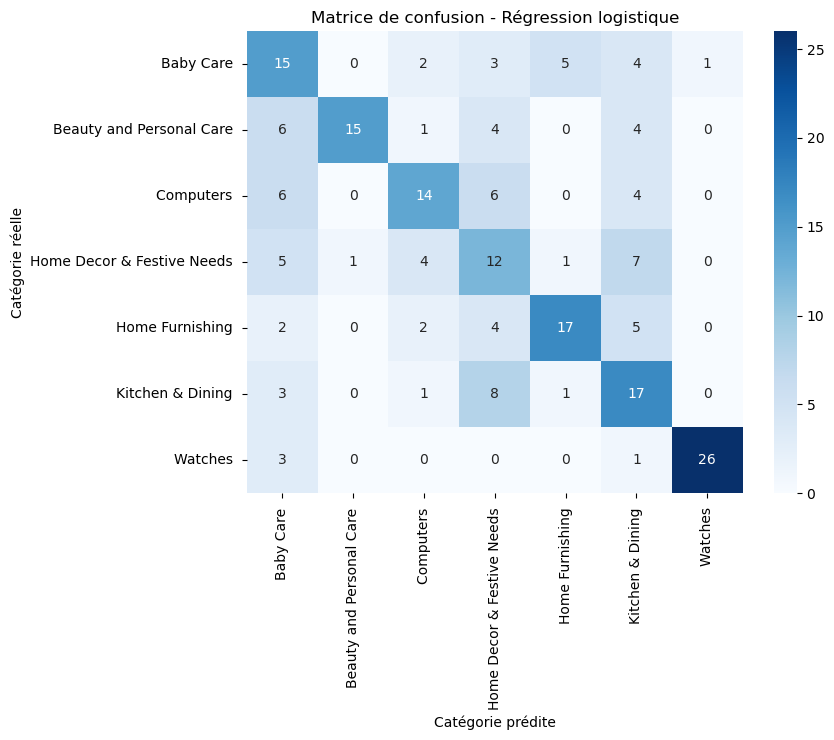

In [39]:
# 1. Entraînement du modèle
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_df, y_train)

# 2. Prédictions
y_train_pred = clf.predict(X_train_df)
y_test_pred = clf.predict(X_test_df)

# 3. Calcul des accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Accuracy sur l'ensemble d'entraînement : {train_accuracy:.4f}")
print(f"Accuracy sur l'ensemble de test : {test_accuracy:.4f}")

# 4. Rapport de classification sur test
print("\nRapport de classification (test) :")
print(classification_report(y_test, y_test_pred))

# 5. Matrice de confusion sur test
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Catégorie prédite')
plt.ylabel('Catégorie réelle')
plt.title('Matrice de confusion - Régression logistique')
plt.show()

| Modèle   | Accuracy (train) | Accuracy (test) | Macro F1 (test) | Weighted F1 (test) |
|----------|------------------|-----------------|-----------------|--------------------|
| BERT     | 0.98            | 0.91           | 0.91            | 0.91               |
| DeBERTa  | 0.68            | 0.55           | 0.57            | 0.57               |


Les performances en classification montrent une nette supériorité de BERT sur DeBERTa dans ce contexte.
BERT atteint une accuracy de 91 % sur le jeu de test, ainsi qu’un score F1 macro et pondéré de 0,91, traduisant une excellente capacité à bien classer l’ensemble des catégories.
À l’inverse, DeBERTa obtient des scores nettement plus faibles (accuracy test : 55 %; F1 macro : 0,57), indiquant que le modèle peine à apprendre la tâche de classification sur ces données.

Ces résultats suggèrent que, dans ce cas d’usage précis, les embeddings générés par BERT sont beaucoup plus adaptés à la classification automatique des produits que ceux produits par DeBERTa.

## Analyse de la Feature Importance globale et locale du modèle DeBERTa

L’interprétabilité des modèles de NLP modernes comme DeBERTa est cruciale pour valider leur robustesse et identifier les biais.

Dans cette section, nous analysons :

- L’importance globale des features : Cela permet d’identifier quelles dimensions des vecteurs d’embeddings générés par DeBERTa sont réellement utilisées par le modèle pour prendre ses décisions. Même si chaque dimension n’a pas de signification humaine directe, cette analyse met en évidence les composantes du signal qui contribuent le plus à la classification, et montre que l’information utile est concentrée dans certaines directions du vecteur.

- L’importance locale : Nous expliquons comment le modèle raisonne pour des prédictions individuelles, c’est-à-dire quels éléments du texte influencent une décision précise.

Méthodes utilisées :

- Approche globale : Permutation Feature Importance sur les embeddings CLS pour mesurer l’influence de chaque dimension sur la performance globale du modèle.

- Approche locale : SHAP (SHapley Additive exPlanations) et exemples contrefactuels pour visualiser l’impact des différentes parties du texte sur une prédiction donnée.

Cette démarche permet non seulement de mieux comprendre comment DeBERTa exploite l’information textuelle, mais aussi de justifier la pertinence de son utilisation pour la classification automatique, en montrant que ses prédictions reposent sur des signaux internes identifiables et non sur des artefacts aléatoires.

### Importance globale des features

Pour évaluer l’importance de chaque dimension des embeddings DeBERTa, nous utilisons la méthode de permutation importance. Cette approche consiste à perturber, une à une, les colonnes du jeu de test : pour chaque dimension, on mélange aléatoirement ses valeurs entre les exemples, tout en laissant les autres dimensions inchangées. On mesure alors la baisse de performance du modèle (ici l’accuracy).

Si la permutation d’une dimension entraîne une chute notable des performances, cela signifie que le modèle s’appuyait fortement sur cette dimension pour ses prédictions. À l’inverse, si la permutation n’a pas d’effet, la dimension n’apporte pas d’information utile à la décision.

Cette méthode, automatisée dans scikit-learn, permet ainsi d’identifier quelles composantes de l’espace d’embedding sont réellement exploitées par le modèle, et d’interpréter de façon quantitative la contribution de chaque feature à la classification.

In [42]:
# Calcul de l'importance par permutation
result = permutation_importance(
    clf,            # le modèle entraîné
    X_test_df,      # DataFrame des embeddings DeBERTa avec noms de colonnes
    y_test,         # labels de test
    n_repeats=10,   # plus de répétitions pour plus de stabilité
    random_state=42,
    n_jobs=-1
)

# Mise en forme des résultats
df_importance = pd.DataFrame({
    'Feature': X_test_df.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)

# Affichage des 20 dimensions les plus importantes
df_importance.head(20)

,Feature,Importance,Std
586,deberta_586,0.073810,0.023546
596,deberta_596,0.046667,0.012919
743,deberta_743,0.038571,0.016281
358,deberta_358,0.027619,0.014723
208,deberta_208,0.021905,0.009331
247,deberta_247,0.017143,0.010257
228,deberta_228,0.014286,0.014444
451,deberta_451,0.012381,0.008303
547,deberta_547,0.012381,0.012454
241,deberta_241,0.006667,0.012084


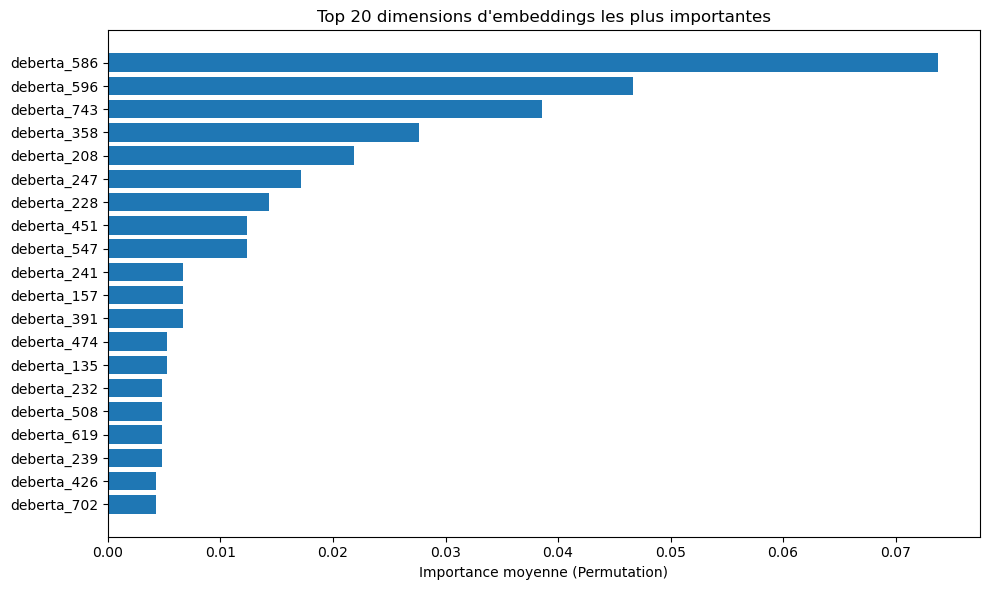

In [43]:
plt.figure(figsize=(10,6))
plt.barh(
    df_importance.head(20)['Feature'][::-1],  # pour avoir la plus importante en haut
    df_importance.head(20)['Importance'][::-1]
)
plt.xlabel("Importance moyenne (Permutation)")
plt.title("Top 20 dimensions d'embeddings les plus importantes")
plt.tight_layout()
plt.show()

L’analyse de la permutation importance appliquée aux dimensions des embeddings DeBERTa montre que, parmi les centaines de dimensions du vecteur, quelques-unes ressortent avec une importance plus marquée pour la performance du modèle de classification. Cependant, même pour la dimension la plus importante, la valeur absolue reste modérée, et la majorité des dimensions ont une importance très faible.

Cela indique que l’information utile pour la classification est dispersée sur plusieurs dimensions : aucune composante n’est à elle seule déterminante. Le modèle exploite donc une combinaison de signaux faibles provenant de différentes directions du vecteur d’embedding.

En pratique, cette analyse :

- Montre que le modèle s’appuie sur certaines dimensions plus que d’autres, mais sans dépendre d’une seule caractéristique dominante.

- Suggère qu’une réduction de dimensionnalité pourrait être envisagée, car beaucoup de dimensions sont peu ou pas utilisées.

- Confirme que le modèle ne se base pas sur des signaux aléatoires : les dimensions les plus importantes contribuent effectivement à la performance, même si leur effet est limité.

Ce constat est cohérent avec ce que l’on observe généralement sur les modèles à embeddings : la décision finale repose sur la combinaison de plusieurs signaux faibles, plutôt que sur une seule dimension très discriminante.

###  Importance locale

Alors que l’analyse globale des features permet de comprendre quelles dimensions des embeddings DeBERTa sont exploitées par le modèle dans l’ensemble des prédictions, l’importance locale vise à expliquer, pour chaque prédiction individuelle, quels éléments du texte ou quelles dimensions de l’embedding ont le plus influencé la décision du modèle.

L’interprétabilité locale est essentielle pour valider la robustesse d’un modèle de NLP moderne comme DeBERTa, en identifiant les signaux spécifiques qui conduisent à une classification donnée. Elle permet de répondre à des questions telles que : “Pourquoi ce texte a-t-il été classé dans cette catégorie ?”.

Dans cette section, nous utilisons des outils d’explicabilité comme SHAP (SHapley Additive exPlanations) ou des exemples contrefactuels pour visualiser et quantifier l’impact des différentes parties du texte ou des dimensions de l’embedding sur la prédiction du modèle. Cette démarche permet d’ouvrir la “boîte noire” de DeBERTa et de s’assurer que ses décisions reposent sur des signaux pertinents et interprétables, plutôt que sur des corrélations aléatoires ou des biais cachés.

In [55]:
# 1. Sélectionner un échantillon à expliquer
X_explain = X_test_df.iloc[:10]

# 2. Créer un explainer SHAP adapté à un modèle scikit-learn
explainer = shap.Explainer(clf, X_test_df)

# 3. Calculer les valeurs SHAP pour l'échantillon choisi
shap_values = explainer(X_explain)

In [77]:
def expliquer_prediction_locale(
    idx,
    X_explain,
    shap_values,
    clf,
    df_reduit_deberta,
    top_n=10,
    texte_col='description_pretraitee',
    classe_col='niveau_categorie_1'
):
    """
    Affiche une explication locale SHAP pour l'exemple d'indice idx dans X_explain.

    Paramètres :
    - idx : indice de l'exemple dans X_explain (0 pour le premier)
    - X_explain : DataFrame des exemples à expliquer (features)
    - shap_values : objet SHAP (sortie de explainer(X_explain))
    - clf : modèle de classification (doit avoir .predict et .classes_)
    - df_reduit_deberta : DataFrame d'origine contenant le texte et la vraie classe
    - top_n : nombre de dimensions d'embedding à afficher
    - texte_col : nom de la colonne contenant le texte
    - classe_col : nom de la colonne contenant la vraie classe
    """

    # Trouver la classe prédite et son index
    class_pred = clf.predict(X_explain.iloc[[idx]])[0]
    class_index = list(clf.classes_).index(class_pred)

    # Extraire les valeurs SHAP pour cet exemple et cette classe
    shap_vals_ex = shap_values.values[idx, :, class_index]

    # Créer le DataFrame trié des features importantes
    df_shap = pd.DataFrame({
        'feature': X_explain.columns,
        'shap_value': shap_vals_ex,
        'abs_shap_value': np.abs(shap_vals_ex)
    })
    df_shap_sorted = df_shap.sort_values('abs_shap_value', ascending=False)
    top_features = df_shap_sorted.head(top_n)

    # Récupérer texte et vraie classe
    idx_df = X_explain.index[idx]
    texte = df_reduit_deberta.loc[idx_df, texte_col]
    true_class = df_reduit_deberta.loc[idx_df, classe_col]

    # Affichage lisible
    print("======== Explication locale de la prédiction ========")
    print("Texte analysé :")
    print(texte[:400] + '...' if len(texte) > 400 else texte)
    print("-----------------------------------------------------")
    print("Classe réelle :", true_class)
    print("Classe prédite :", class_pred)
    print("-----------------------------------------------------")
    print(f"Top {top_n} dimensions de l'embedding DeBERTa les plus influentes :")
    for i, row in top_features.iterrows():
        print(f"  - {row['feature']}: {row['shap_value']:.3f}")
    print("=====================================================")
    
    # Pour la waterfall plot, il faut aussi les valeurs de base et les valeurs des features
    base_val_ex = shap_values.base_values[idx, class_index]
    data_ex = shap_values.data[idx]

    # On sélectionne les top features pour la plot
    top_indices = df_shap_sorted.index[:top_n].tolist()
    shap_vals_top = shap_vals_ex[top_indices]
    data_top = data_ex[top_indices]
    feature_names_top = df_shap_sorted['feature'].iloc[:top_n].tolist()

    # Créer un nouvel objet Explanation avec ces features seulement
    explanation_top = shap.Explanation(
        values=shap_vals_top,
        base_values=base_val_ex,
        data=data_top,
        feature_names=feature_names_top
    )

    # Afficher la waterfall plot
    shap.plots.waterfall(explanation_top, max_display=top_n)
    plt.show()

======== Explication locale de la prédiction ========
Texte analysé :
Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and lov...
-----------------------------------------------------
Classe réelle : Home Furnishing 
Classe prédite : Baby Care 
-----------------------------------------------------
Top 10 dimensions de l'embedding DeBERTa les plus influentes :
  - deberta_208: 0.365
  - deberta_234: 0.186
  - deberta_318: 0.157
  - deberta_247: 0.155
  - deberta_54: 0.144
  - deberta_305: 0.144
  - deberta_596: -0.119
  - deberta_136: 0.108
  - deberta_599: -0.097
  - deberta_232: 0.092


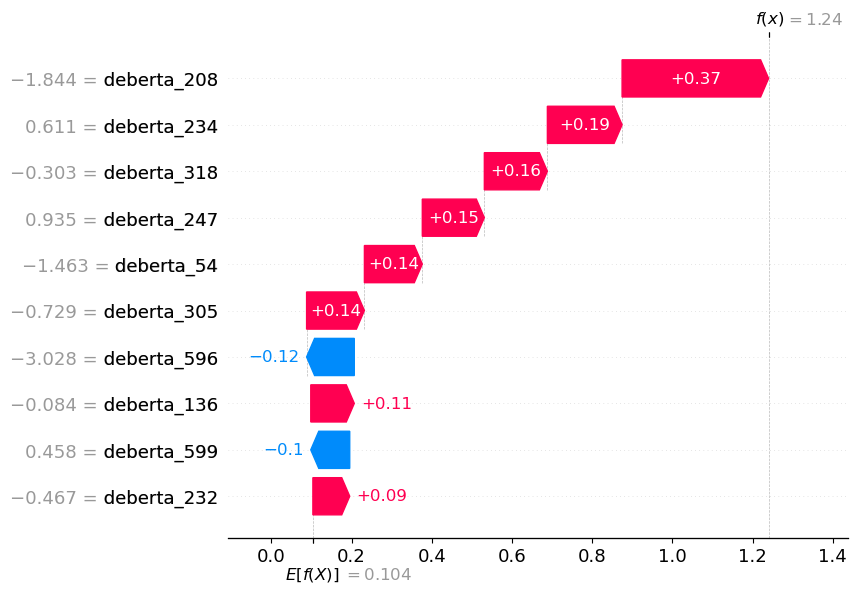

In [78]:
expliquer_prediction_locale(
    idx=0,
    X_explain=X_explain,
    shap_values=shap_values,
    clf=clf,
    df_reduit_deberta=df_reduit_deberta,
    top_n=10
)

======== Explication locale de la prédiction ========
Texte analysé :
Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been expor...
-----------------------------------------------------
Classe réelle : Baby Care 
Classe prédite : Kitchen & Dining 
-----------------------------------------------------
Top 10 dimensions de l'embedding DeBERTa les plus influentes :
  - deberta_586: 0.771
  - deberta_81: 0.591
  - deberta_596: -0.507
  - deberta_228: 0.355
  - deberta_451: -0.286
  - deberta_743: -0.252
  - deberta_358: -0.194
  - deberta_91: 0.157
  - deberta_279: -0.156
  - deberta_134: 0.150


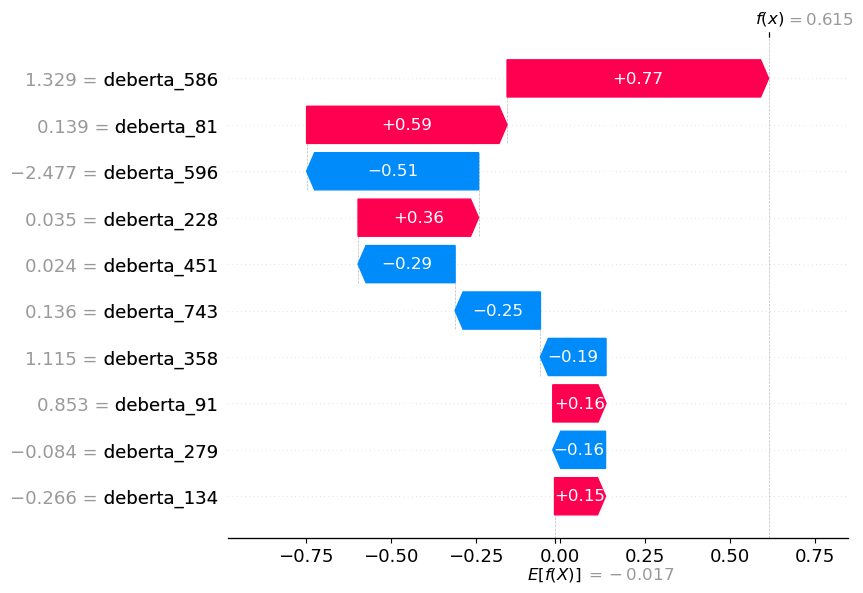

In [79]:
expliquer_prediction_locale(
    idx=2,
    X_explain=X_explain,
    shap_values=shap_values,
    clf=clf,
    df_reduit_deberta=df_reduit_deberta,
    top_n=10 
)

======== Explication locale de la prédiction ========
Texte analysé :
Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print Cotton Floral King sized Double Bedsheet (1 bed sheet 2 pillow cover, White) Price: Rs. 998 This nice bed sheet made up of 100% cotton to give you comfort. This bed sheet is hand printed. This bedsheet gives nice look to your room And its fast colour and good quality gives this bedsheet long life.,Specif...
-----------------------------------------------------
Classe réelle : Home Furnishing 
Classe prédite : Beauty and Personal Care 
-----------------------------------------------------
Top 10 dimensions de l'embedding DeBERTa les plus influentes :
  - deberta_596: 0.519
  - deberta_586: 0.496
  - deberta_241: 0.481
  - deberta_684: 0.410
  - deberta_247: 0.395
  - deberta_305: 0.292
  - deberta_530: 0.258
  - deberta_451: -0.192
  - deberta_65: 0.188
  - deberta_279: 0.184


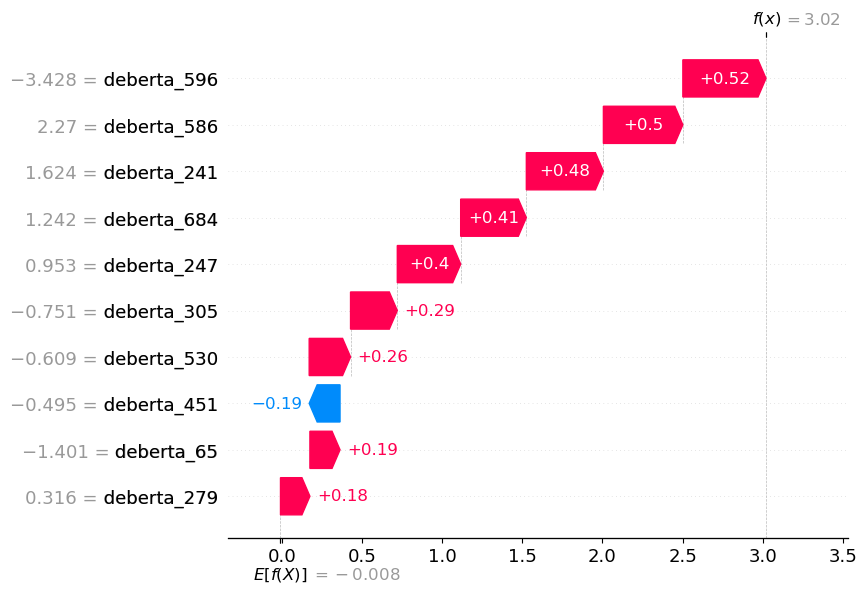

In [81]:
expliquer_prediction_locale(
    idx=4,
    X_explain=X_explain,
    shap_values=shap_values,
    clf=clf,
    df_reduit_deberta=df_reduit_deberta,
    top_n=10 
)

Le modèle peut se tromper, mais il ne décide pas au hasard.<br>
Même quand la classe prédite est fausse (ce qui est le cas dans les deux exemples), certaines dimensions de l’embedding ont une influence marquée sur la décision.<br>
=> Cela montre que le modèle exploite certains signaux appris dans l’espace d’embedding — même s’il se trompe parfois.

Des dimensions spécifiques ont un impact fort, variable selon le texte.<br>
Exemple : deberta_586 est fortement positif dans le deuxième exemple (valeur 0.77).<br>
=> Ça suggère que certaines dimensions capturent des motifs ou thématiques spécifiques, comme “linge de maison”, “tissu”, etc.

L’analyse locale de la prédiction met en évidence que certaines dimensions des embeddings DeBERTa influencent fortement les décisions du modèle, même lorsqu’il se trompe. Cela montre que le modèle repose sur des signaux appris et non aléatoires. Plusieurs dimensions identifiées localement comme importantes sont également présentes dans l’analyse globale, renforçant la cohérence du modèle. Enfin, ces erreurs de classification s’expliquent souvent par une proximité sémantique entre certaines catégories, suggérant des limites du dataset ou des zones d’ambiguïté dans les descriptions produits.